In [9]:
import os
import pandas as pd
import numpy as np

In [10]:
experiment_data_folders_path = os.path.join(os.getcwd(), "Data", "Pretest")
print(experiment_data_folders_path)

/home/jovyan/Masterarbeit/Data/Pretest


In [22]:
# for files with a single column of data
def read_lines_from_file_into_df(file_path, column_names):
    # Read all lines from the file
    with open(file_path, "r") as f:
        lines = f.readlines()
    
    # Strip any whitespace characters from the ends of the lines
    data = [line.strip() for line in lines]
    
    # Create a DataFrame from the data
    df = pd.DataFrame([data], columns=column_names)
    
    return df

# for files with multiple columns of data
def get_df_from_file(file_path, column_names):
    df = pd.read_csv(file_path, sep='\t', header=None, names = column_names)
    return df

# for files with a single data point
def read_first_line_from_file(file_path):
    lines = []
    with open(file_path, "r") as f:
        for line in f:
            lines.append(line)

    return lines[0]

def get_movement_timestamps_df_from_interaction_events_df(interaction_events_df):
    grab_events = interaction_events_df[interaction_events_df['EventType'] == 'Grab']
    release_events = interaction_events_df[interaction_events_df['EventType'] == 'Release']
    
    grab_events = grab_events.reset_index(drop=True)
    release_events = release_events.reset_index(drop=True)

    movement_timestamps_df = pd.DataFrame({
        'GrabTimestamp': grab_events['Timestamp'],
        'ReleaseTimestamp': release_events['Timestamp']
    })

    return movement_timestamps_df

def calculate_distance_and_speed(grab_timestamp, release_timestamp, movement_df):
    # Filter the movement data between the grab and release timestamps
    movement_data = movement_df[(movement_df['Timestamp'] >= grab_timestamp) & (movement_df['Timestamp'] <= release_timestamp)]
    
    distances = np.sqrt((movement_data['PositionX'].diff()**2) + 
                        (movement_data['PositionY'].diff()**2) + 
                        (movement_data['PositionZ'].diff()**2))
    
    total_distance = distances.sum()
    
    time_duration = release_timestamp - grab_timestamp
    
    # Calculate speed (distance / time)
    average_speed = total_distance / time_duration if time_duration > 0 else 0
    
    return total_distance, average_speed

def get_grip_pressure(grab_timestamp, release_timestamp, movement_df):
    # subtract a tolerance (seconds) from grab_timestamp, as grip pressure can rise before item is fully grabbed 
    tolerance = 0.5
    movement_data = movement_df[(movement_df['Timestamp'] >= grab_timestamp - tolerance) & (movement_df['Timestamp'] <= release_timestamp)]
    grip_pressure = movement_data['GripPressure'].mean()
    #print(grip_pressure)

    return grip_pressure

def get_round_type(grab_timestamp, round_data):
    for i, row in round_data.iterrows():
        if grab_timestamp <= row['RoundEndTimestamp']:
            return row['RoundType']
    return None

def get_round_number(grab_timestamp, round_data):
    for i, row in round_data.iterrows():
        if grab_timestamp <= row['RoundEndTimestamp']:
            return row['RoundNumber']
    return None


def get_mistakes_for_rounds(round_data_df, round_type):
    rounds = round_data_df[round_data_df['RoundType'] == round_type]
    mistakes = []
    for i in range(len(rounds)):  # Get all available rounds
        round_mistakes = rounds.iloc[i]['TotalItems'] - rounds.iloc[i]['CorrectItems']
        mistakes.append(round_mistakes)
    return mistakes

In [47]:
IS_BETWEEN_SUBJECTS = False
NUMBER_OF_ROUNDS = 10

participants_df = pd.DataFrame()

# Iterate through each folder in the directory
for folder_name in os.listdir(experiment_data_folders_path):
    # Skip if it's not a directory or if it's a hidden/system directory (starts with '.')
    if not os.path.isdir(os.path.join(experiment_data_folders_path, folder_name)) or folder_name.startswith('.'):
        continue

    print('folder name: ' + folder_name)
    
    folder_path = os.path.join(experiment_data_folders_path, folder_name)

    interaction_events_df = get_df_from_file(os.path.join(folder_path, 'InteractionEvents.txt'), 
                                             ['Timestamp', 'EventType', 'Interactor', 'Interactable'])
    interaction_events_df['Timestamp'] = interaction_events_df['Timestamp'].map(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
    interaction_events_df = interaction_events_df.astype({'Timestamp': 'float'})

    movement_timestamps_df = get_movement_timestamps_df_from_interaction_events_df(interaction_events_df)

    dominant_hand = read_first_line_from_file(os.path.join(folder_path, 'DominantHand.txt'))

    dominant_hand_movement_df = get_df_from_file(os.path.join(folder_path, dominant_hand + '.txt'), 
                                                ['Timestamp', 'PositionX', 'PositionY', 'PositionZ', 
                                                 'RotationX', 'Rotation Y', 'RotationZ', 'RotationW', 
                                                 'GripPressure'])

    dominant_hand_movement_df = dominant_hand_movement_df.apply(lambda col: col.map(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x))
    dominant_hand_movement_df = dominant_hand_movement_df.astype('float')

    distances = []
    speeds = []
    grip_pressures = []
    
    # Iterate through each row in movement_timestamps_df
    for index, row in movement_timestamps_df.iterrows():
        grab_timestamp = row['GrabTimestamp']
        release_timestamp = row['ReleaseTimestamp']
        distance, speed = calculate_distance_and_speed(grab_timestamp, release_timestamp, dominant_hand_movement_df)
        grip_pressure = get_grip_pressure(grab_timestamp, release_timestamp, dominant_hand_movement_df)
        distances.append(distance)
        speeds.append(speed)
        grip_pressures.append(grip_pressure)

    # Add the results to the DataFrame
    movement_timestamps_df['Distance'] = distances
    movement_timestamps_df['Speed'] = speeds
    movement_timestamps_df['GripPressure'] = grip_pressures
    
    round_data_df = get_df_from_file(os.path.join(folder_path, 'RoundData.txt'), 
                                    ['RoundEndTimestamp', 'RoundNumber', 'RoundType', 'CorrectItems', 'TotalItems'])
    round_data_df['RoundEndTimestamp'] = round_data_df['RoundEndTimestamp'].map(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
    round_data_df = round_data_df.astype({'RoundEndTimestamp': 'float'})

    movement_timestamps_df['RoundType'] = movement_timestamps_df['GrabTimestamp'].apply(lambda x: get_round_type(x, round_data_df))
    movement_timestamps_df['RoundNumber'] = movement_timestamps_df['GrabTimestamp'].apply(lambda x: get_round_number(x, round_data_df))

    print(movement_timestamps_df.head())
    # Group by RoundNumber and calculate mean values
    round_means_df = movement_timestamps_df.groupby('RoundNumber').agg({
        'Distance': 'mean',
        'Speed': 'mean',
        'GripPressure': 'mean'
    }).reset_index()
    #print(round_means_df)
  
    movement_timestamps_low_cl_df = movement_timestamps_df[movement_timestamps_df['RoundType'] == 'LowCognitiveLoad']
    movement_timestamps_high_cl_df = movement_timestamps_df[movement_timestamps_df['RoundType'] == 'HighCognitiveLoad']
    
    # df containing raw survey answers
    survey_answers_raw_df = read_lines_from_file_into_df(os.path.join(folder_path, 'SurveyAnswers.txt'), 
                                                     ['GeneralCheck', 
                                                    'LowCLMentalDemand', 'LowCLPhysicalDemand', 'LowCLTemporalDemand', 
                                                    'LowCLPerformance', 'LowCLEffort', 'LowCLFrustration',                                     
                                                    'HighCLMentalDemand', 'HighCLPhysicalDemand', 'HighCLTemporalDemand', 
                                                    'HighCLPerformance', 'HighCLEffort', 'HighCLFrustration',
                                                    'LeftHandConsciousMovement', 'RightHandConsciousMovement',
                                                    'Presence1', 'Presence2', 'Presence3', 'Presence4', 'Presence5', 'Presence6',
                                                    'ExperienceVR1', 'ExperienceVR2', 'ExperienceVR3',
                                                    'NauseaNausea', 'NauseaDizziness', 
                                                    'VestibularDisorientation', 'VestibularImbalance',
                                                    'OculomotorFatigue', 'OculomotorDiscomfort',
                                                    'Gender', 'Education', 'EmployementStatus', 'Age'
                                                   ])


    # convert all to int except GeneralCheck, Gender, Education and EmploymentStatus
    survey_answers_raw_df = survey_answers_raw_df.astype({'LowCLMentalDemand': 'int32', 'LowCLPhysicalDemand': 'int32', 'LowCLTemporalDemand': 'int32', 
                                                          'LowCLPerformance': 'int32', 'LowCLEffort': 'int32', 'LowCLFrustration': 'int32', 
                                                          'HighCLMentalDemand': 'int32', 'HighCLPhysicalDemand': 'int32', 'HighCLTemporalDemand': 'int32', 
                                                          'HighCLPerformance': 'int32', 'HighCLEffort': 'int32', 'HighCLFrustration': 'int32',
                                                          'LeftHandConsciousMovement': 'int32', 'RightHandConsciousMovement': 'int32',
                                                          'Presence1': 'int32', 'Presence2': 'int32', 'Presence3': 'int32', 'Presence4': 'int32', 'Presence5': 'int32', 'Presence6': 'int32',
                                                          'ExperienceVR1': 'int32', 'ExperienceVR2': 'int32', 'ExperienceVR3': 'int32',
                                                          'NauseaNausea': 'int32', 'NauseaDizziness': 'int32', 'VestibularDisorientation': 'int32', 'VestibularImbalance': 'int32',
                                                          'OculomotorFatigue': 'int32', 'OculomotorDiscomfort': 'int32',
                                                          'Age': 'int32'
                                                         })
    
    # df containing calculated values of constructs
    survey_answers_df = pd.DataFrame()
    survey_answers_df['GeneralCheck'] = survey_answers_raw_df['GeneralCheck']
    survey_answers_df['NASA-TLX-LowCL'] = (survey_answers_raw_df['LowCLMentalDemand'] + survey_answers_raw_df['LowCLPhysicalDemand'] + survey_answers_raw_df['LowCLTemporalDemand'] + survey_answers_raw_df['LowCLPerformance'] + survey_answers_raw_df['LowCLEffort'] + survey_answers_raw_df['LowCLFrustration']) / 6
    survey_answers_df['NASA-TLX-HighCL'] = (survey_answers_raw_df['HighCLMentalDemand'] + survey_answers_raw_df['HighCLPhysicalDemand'] + survey_answers_raw_df['HighCLTemporalDemand'] + survey_answers_raw_df['HighCLPerformance'] + survey_answers_raw_df['HighCLEffort'] + survey_answers_raw_df['HighCLFrustration']) / 6
    survey_answers_df['LeftHandConsciousMovement'] = survey_answers_raw_df['LeftHandConsciousMovement']
    survey_answers_df['RightHandConsciousMovement'] = survey_answers_raw_df['RightHandConsciousMovement']
    survey_answers_df['Presence'] = (survey_answers_raw_df['Presence1'] + survey_answers_raw_df['Presence2'] + survey_answers_raw_df['Presence3'] + survey_answers_raw_df['Presence4'] + survey_answers_raw_df['Presence5'] + survey_answers_raw_df['Presence6']) / 6
    survey_answers_df['ExperienceVR'] = (survey_answers_raw_df['ExperienceVR1'] + survey_answers_raw_df['ExperienceVR2'] + survey_answers_raw_df['ExperienceVR3']) / 3
    survey_answers_df['CSQ-VR-Nausea'] = survey_answers_raw_df['NauseaNausea'] + survey_answers_raw_df['NauseaDizziness']
    survey_answers_df['CSQ-VR-Vestibular'] = survey_answers_raw_df['VestibularDisorientation'] + survey_answers_raw_df['VestibularImbalance']
    survey_answers_df['CSQ-VR-Oculomotor'] = survey_answers_raw_df['OculomotorFatigue'] + survey_answers_raw_df['OculomotorDiscomfort']
    survey_answers_df['CSQ-VR'] = survey_answers_df['CSQ-VR-Nausea'] + survey_answers_df['CSQ-VR-Vestibular'] + survey_answers_df['CSQ-VR-Oculomotor']
    survey_answers_df['Gender'] = survey_answers_raw_df['Gender']
    survey_answers_df['Education'] = survey_answers_raw_df['Education']
    survey_answers_df['EmployementStatus'] = survey_answers_raw_df['EmployementStatus']
    survey_answers_df['Age'] = survey_answers_raw_df['Age']
    
    participant_df = pd.DataFrame({'FolderName': folder_name,
                                   'MeanDistDomHandLowCL': movement_timestamps_low_cl_df['Distance'].mean(),
                                   'MeanSpeedDomHandLowCL': movement_timestamps_low_cl_df['Speed'].mean(),
                                   'MeanGripPressureDomHandLowCL': movement_timestamps_low_cl_df['GripPressure'].mean(),
                                   'MeanDistDomHandHighCL': movement_timestamps_high_cl_df['Distance'].mean(),
                                   'MeanSpeedDomHandHighCL': movement_timestamps_high_cl_df['Speed'].mean(),
                                   'MeanGripPressureDomHandHighCL': movement_timestamps_high_cl_df['GripPressure'].mean(),
                                  }, index=[0])

    # Add mean Distance, Speed and GripPressure columns for each round
    for _, row in round_means_df.iterrows():
        round_number = int(row['RoundNumber'])
        participant_df[f'MeanDistanceRound{round_number}'] = row['Distance']
        participant_df[f'MeanSpeedRound{round_number}'] = row['Speed']
        participant_df[f'MeanGripPressureRound{round_number}'] = row['GripPressure']

    low_cl_mistakes = get_mistakes_for_rounds(round_data_df, 'LowCognitiveLoad')
    high_cl_mistakes = get_mistakes_for_rounds(round_data_df, 'HighCognitiveLoad')

    # Add the mistakes columns dynamically
    for i in range(len(low_cl_mistakes)):
        participant_df[f'MistakesLowCL{i+1}'] = low_cl_mistakes[i]
    for i in range(len(high_cl_mistakes)):
        participant_df[f'MistakesHighCL{i+1}'] = high_cl_mistakes[i]

    participant_df['MeanMistakesLowCL'] = np.mean(low_cl_mistakes)
    participant_df['MeanMistakesHighCL'] = np.mean(high_cl_mistakes)
    
    participant_df = pd.concat([participant_df.reset_index(drop=True), survey_answers_df.reset_index(drop=True)], axis=1)
        
    participants_df = pd.concat([participants_df, participant_df], ignore_index = True)
    
#print(participants_df.head())
participants_df.to_csv('Pretest.csv', sep = ';', decimal = ',', index=False)

folder name: 3
   GrabTimestamp  ReleaseTimestamp  Distance     Speed  GripPressure  \
0       42.02405          45.72687  2.879395  0.777622      0.871680   
1       81.00586          85.28149  2.709428  0.633691      0.888474   
2      128.07750         131.40490  2.870104  0.862567      0.861574   
3      134.21800         136.97530  2.098817  0.761186      0.838541   
4      139.56420         142.54320  2.178718  0.731359      0.830077   

           RoundType  RoundNumber  
0   LowCognitiveLoad            1  
1   LowCognitiveLoad            2  
2  HighCognitiveLoad            3  
3  HighCognitiveLoad            3  
4  HighCognitiveLoad            3  
folder name: 2
   GrabTimestamp  ReleaseTimestamp  Distance     Speed  GripPressure  \
0       35.18735          37.38589  2.147164  0.976632      0.794305   
1       38.79327          40.14249  1.712356  1.269145      0.721112   
2       42.91422          44.75101  2.562714  1.395213      0.772984   
3       47.11734          47.1314

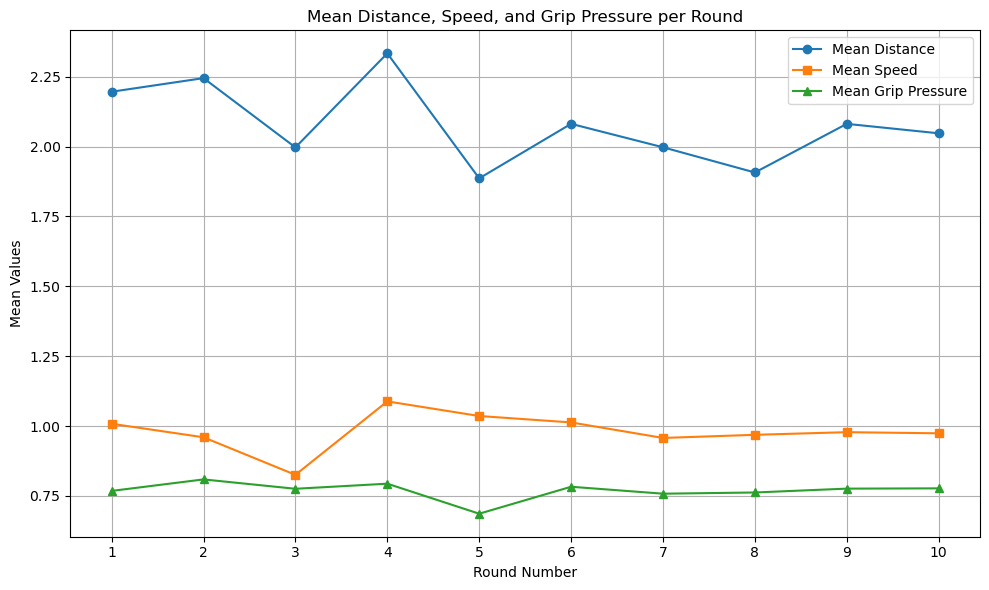

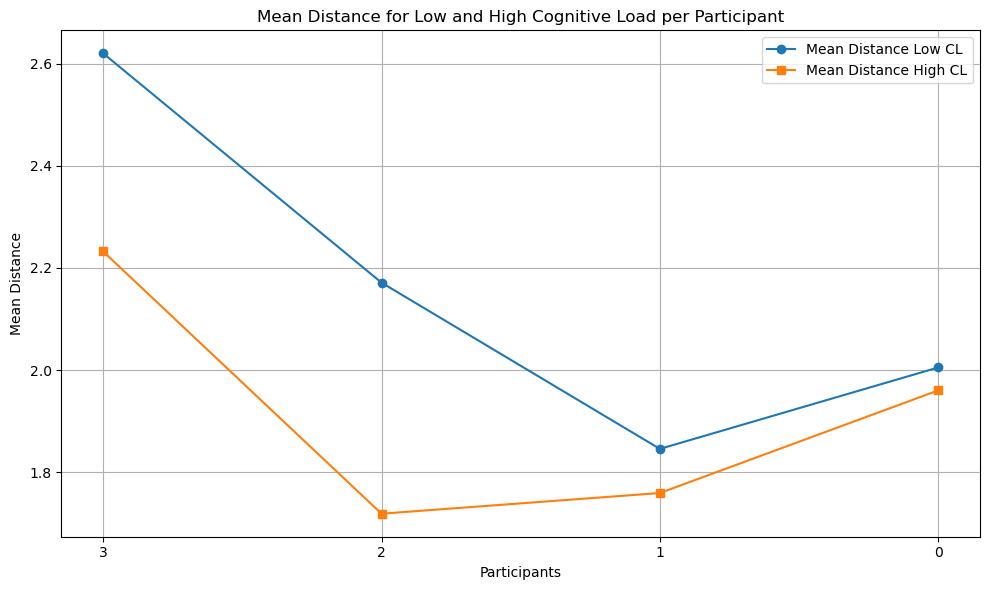

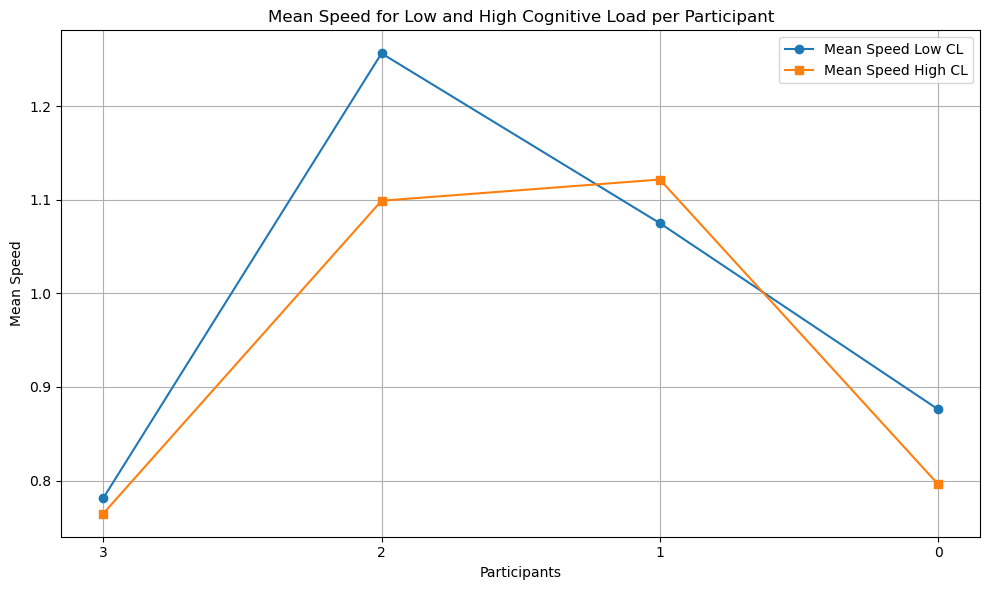

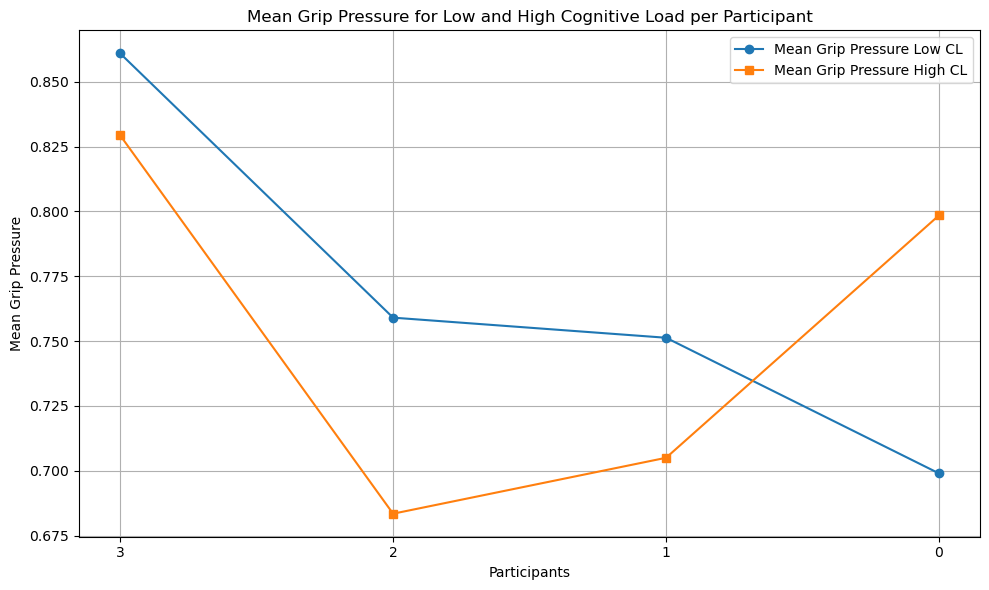

In [46]:
import matplotlib.pyplot as plt

# Statistics and Visualizations

rounds = range(1, NUMBER_OF_ROUNDS + 1)
mean_distance = [participants_df[f'MeanDistanceRound{round}'].mean() for round in rounds]
mean_speed = [participants_df[f'MeanSpeedRound{round}'].mean() for round in rounds]
mean_grip_pressure = [participants_df[f'MeanGripPressureRound{round}'].mean() for round in rounds]

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(rounds, mean_distance, marker='o', label='Mean Distance')
plt.plot(rounds, mean_speed, marker='s', label='Mean Speed')
plt.plot(rounds, mean_grip_pressure, marker='^', label='Mean Grip Pressure')

plt.xlabel('Round Number')
plt.ylabel('Mean Values')
plt.title('Mean Distance, Speed, and Grip Pressure per Round')
plt.legend()
plt.grid(True)
plt.xticks(rounds)  # Set x-axis to show round numbers
plt.tight_layout()

# Save or show the plot
plt.savefig('participants_mean_plot.png')  # To save the plot as a file
plt.show()  # To display the plot

# Plot the data for Mean Distance
plt.figure(figsize=(10, 6))

plt.plot(participants_df['FolderName'], participants_df['MeanDistDomHandLowCL'], marker='o', label='Mean Distance Low CL')
plt.plot(participants_df['FolderName'], participants_df['MeanDistDomHandHighCL'], marker='s', label='Mean Distance High CL')

plt.xlabel('Participants')
plt.ylabel('Mean Distance')
plt.title('Mean Distance for Low and High Cognitive Load per Participant')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or show the plot
plt.savefig('mean_distance_per_participant.png')  # To save the plot as a file
plt.show()  # To display the plot

# Plot the data for Mean Speed
plt.figure(figsize=(10, 6))

plt.plot(participants_df['FolderName'], participants_df['MeanSpeedDomHandLowCL'], marker='o', label='Mean Speed Low CL')
plt.plot(participants_df['FolderName'], participants_df['MeanSpeedDomHandHighCL'], marker='s', label='Mean Speed High CL')

plt.xlabel('Participants')
plt.ylabel('Mean Speed')
plt.title('Mean Speed for Low and High Cognitive Load per Participant')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or show the plot
plt.savefig('mean_speed_per_participant.png')  # To save the plot as a file
plt.show()  # To display the plot

# Plot the data for Mean Grip Pressure
plt.figure(figsize=(10, 6))

plt.plot(participants_df['FolderName'], participants_df['MeanGripPressureDomHandLowCL'], marker='o', label='Mean Grip Pressure Low CL')
plt.plot(participants_df['FolderName'], participants_df['MeanGripPressureDomHandHighCL'], marker='s', label='Mean Grip Pressure High CL')

plt.xlabel('Participants')
plt.ylabel('Mean Grip Pressure')
plt.title('Mean Grip Pressure for Low and High Cognitive Load per Participant')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or show the plot
plt.savefig('mean_grip_pressure_per_participant.png')  # To save the plot as a file
plt.show()  # To display the plot